In [ ]:
 !nvidia-smi

Fri Sep  8 22:11:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%config Completer.use_jedi = False

### 데이터 전처리 수행.
* 학습/검증/테스트 데이터 세트로 나누고 원-핫 인코딩 수행

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음.
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels):

    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형.
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # OHE 적용
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용.
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels )


# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성.
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170498071/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [ ]:
IMAGE_SIZE = 32

### 모델 생성 함수 생성

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    #x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    # cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()

    return model

In [ ]:
create_model(verbose=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                            

### Learning Rate와 Early Stopping을 위한 Callback 생성
**Learning Rate의 동적 변경**은 `ReducLROnPlateau`, **모델 Ealry Stopping**은 `Ealry Stopping` Callback을 이용


In [ ]:
# ModelCheckPoint를 동작시키기 전에 기존 저장된 모델은 모두 삭제
!rm *.hdf5

rm: cannot remove '*.hdf5': No such file or directory


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



model = create_model()
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# [callbacks]: validation loss가 향상되는 모델만 저장
checkpoint_path = '/content/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
mcp_cb = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                         save_best_only=True, save_weights_only=True, mode='min', period=1, verbose=0)

# [ReduceLROnPlateau] : 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)

# [EarlyStopping]10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),
                    callbacks=[mcp_cb, rlr_cb, ely_cb]) # 위에서 지정한 학습 옵션들 넣어주기

Epoch 1/30
1329/1329 [==============================] - 26s 9ms/step - loss: 1.5591 - accuracy: 0.4339 - val_loss: 1.2564 - val_accuracy: 0.5433 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 10s 8ms/step - loss: 1.1063 - accuracy: 0.6082 - val_loss: 0.9478 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.9205 - accuracy: 0.6786 - val_loss: 0.8133 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.8038 - accuracy: 0.7223 - val_loss: 0.7145 - val_accuracy: 0.7565 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.7228 - accuracy: 0.7533 - val_loss: 0.8030 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 12s 9ms/step - loss: 0.6478 - accuracy: 0.7761 - val_loss: 1.0835 - val_accuracy: 0.6628 - lr: 0.0010
Epoch 7/30
1329/1329 [==============================

In [ ]:
# 평가
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 2s 6ms/step - loss: 0.6226 - accuracy: 0.8576


[0.6226043105125427, 0.8575999736785889]

In [ ]:
# 위에서 저장한 가중치들을 확인하자
!ls -lia # 현재 경로 파일 출력 (-1 : 자세히, -i  파일의 inode번호도 출력, -a: 숨김파일 출력)

total 28816
 524304 drwxr-xr-x 1 root root    4096 Sep  8 22:15 .
     33 drwxr-xr-x 1 root root    4096 Sep  8 22:09 ..
3276807 drwxr-xr-x 4 root root    4096 Sep  7 13:23 .config
 524305 drwxr-xr-x 1 root root    4096 Sep  7 13:24 sample_data
    139 -rw-r--r-- 1 root root 3685024 Sep  8 22:12 weights.01-1.26.hdf5
    140 -rw-r--r-- 1 root root 3685024 Sep  8 22:12 weights.02-0.95.hdf5
    141 -rw-r--r-- 1 root root 3685024 Sep  8 22:12 weights.03-0.81.hdf5
    142 -rw-r--r-- 1 root root 3685024 Sep  8 22:12 weights.04-0.71.hdf5
    143 -rw-r--r-- 1 root root 3685024 Sep  8 22:13 weights.07-0.63.hdf5
    144 -rw-r--r-- 1 root root 3685024 Sep  8 22:13 weights.10-0.53.hdf5
    145 -rw-r--r-- 1 root root 3685024 Sep  8 22:13 weights.11-0.52.hdf5
    146 -rw-r--r-- 1 root root 3685024 Sep  8 22:15 weights.17-0.48.hdf5


### 최적 weight를 모델로 재 로딩한 다음에 테스트 데이터로 다시 평가

In [ ]:
model = create_model() # save_weight_only 사용시 가중치를 얹힐 모델 틀은 만들어 놔야 한다
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/weights.17-0.48.hdf5')

In [ ]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 2s 4ms/step - loss: 0.5195 - accuracy: 0.8474


[0.5194981098175049, 0.8474000096321106]

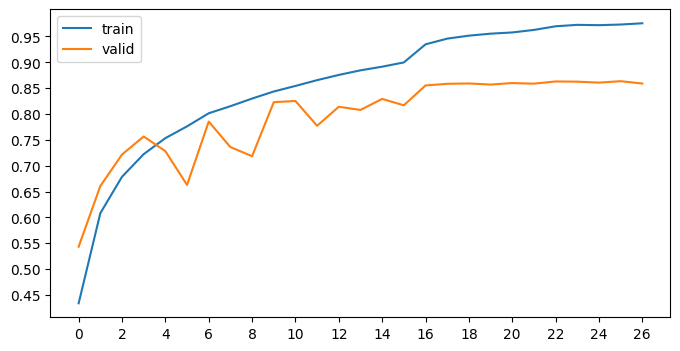

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

show_history(history)

### 필터의 개수를 증가시켜 테스트
* Conv Layer의 필터를 기존보다 2배씩 증가
* 맨 마지막 Conv는 512로 대폭 증가

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
# 원래는 필터수 32였지만 이번엔 두배인 64부터 시작
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 512 filters Conv layer 추가
x = Conv2D(filters=512, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=2)(x)

# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_20 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_28 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_21 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                         

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/30
1329/1329 [==============================] - 29s 16ms/step - loss: 1.9078 - accuracy: 0.2764 - val_loss: 1.5431 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 22s 17ms/step - loss: 1.5037 - accuracy: 0.4123 - val_loss: 1.5942 - val_accuracy: 0.4195 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 19s 15ms/step - loss: 1.3353 - accuracy: 0.4873 - val_loss: 1.1065 - val_accuracy: 0.6135 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 19s 15ms/step - loss: 1.1961 - accuracy: 0.5500 - val_loss: 1.2942 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 20s 15ms/step - loss: 1.0836 - accuracy: 0.6000 - val_loss: 0.9754 - val_accuracy: 0.6604 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 20s 15ms/step - loss: 0.9810 - accuracy: 0.6407 - val_loss: 1.0134 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 2s 6ms/step - loss: 0.9329 - accuracy: 0.8685


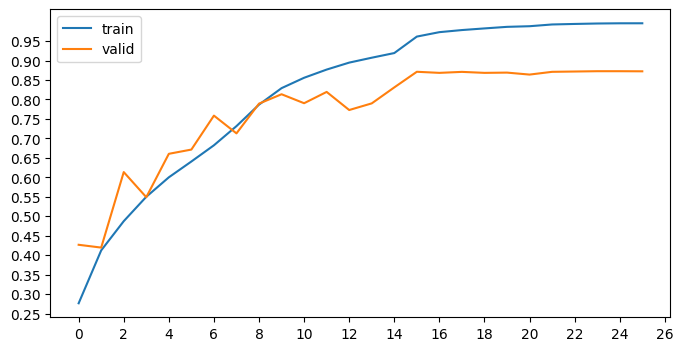

In [ ]:
# 테스트하기
model.evaluate(test_images, test_oh_labels)
show_history(history)

### 맨 마지막 Conv + MaxPooling 대신 맨 마지막 Conv의 Strides를 2로 하여 Feature map 조정
- `stride=2`, `padding=same`일때는 원본사이즈 동일한 피처맵 내는 것이 목적이 아님
- stride=2이고 kernel=(3x3)일때, 최우측 열에는 window가 접근을 못할 수 있는데, 이때 `padding=same`이 해결해준다

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 512 filters Conv layer 추가하되 이후 MaxPooling을 적용하지 않고 strides는 2로 변경하여 출력 feature map 크기 조정
x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_26 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_27 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                         

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),
                    callbacks=[rlr_cb, ely_cb] )

Epoch 1/30
1329/1329 [==============================] - 25s 15ms/step - loss: 1.5926 - accuracy: 0.4242 - val_loss: 1.4313 - val_accuracy: 0.5149 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 19s 15ms/step - loss: 1.1535 - accuracy: 0.5918 - val_loss: 1.2481 - val_accuracy: 0.5835 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 19s 15ms/step - loss: 0.9484 - accuracy: 0.6699 - val_loss: 0.9632 - val_accuracy: 0.6740 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 19s 14ms/step - loss: 0.8319 - accuracy: 0.7141 - val_loss: 1.0351 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 19s 14ms/step - loss: 0.7290 - accuracy: 0.7560 - val_loss: 0.8500 - val_accuracy: 0.7159 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 19s 14ms/step - loss: 0.6268 - accuracy: 0.7943 - val_loss: 0.6166 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 2s 6ms/step - loss: 0.8794 - accuracy: 0.8681


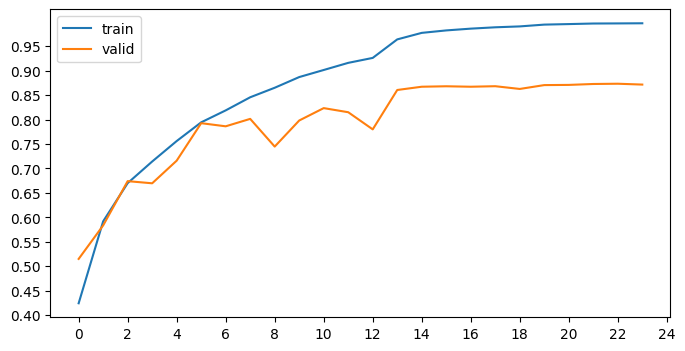

In [ ]:
model.evaluate(test_images, test_oh_labels)
show_history(history)

### Global Average Pooling의 적용
* **`Global Average Pooling`**은 피처맵의 가로x세로의 특정 영역을 Sub sampling 않고, **채널별로 평균 값을 추출**
* **충분히 Feature map의 채널수가 많을 경우** 이를 적용. 채널수가 적다면 Flatten이 유리.
* 채널수 많을 시 Flatten-> Classification Dense Layer로 이어지면서 **많은 파라미터들로 인한 오버피팅 유발 가능성 증대 및 학습 시간 늘어남.**
* 맨 마지막 Feature Map의 채널 수가 충분히 크다면 **`GlobalAveragePooling2D`**를 적용하여 Flatten을 제거하는데 더 유리 할 수 있음.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Flatten 대신 Global AveragePooling 을 적용.
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu', name='fc1')(x)
x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_32 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_44 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_33 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                         

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

# 컴파일
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# 학습
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),
                    callbacks=[rlr_cb, ely_cb] )

Epoch 1/30
1329/1329 [==============================] - 24s 15ms/step - loss: 1.4867 - accuracy: 0.4616 - val_loss: 2.2677 - val_accuracy: 0.3952 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 19s 14ms/step - loss: 1.0496 - accuracy: 0.6323 - val_loss: 0.9979 - val_accuracy: 0.6533 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 18s 14ms/step - loss: 0.8541 - accuracy: 0.7050 - val_loss: 0.9670 - val_accuracy: 0.6777 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 18s 14ms/step - loss: 0.7220 - accuracy: 0.7564 - val_loss: 0.6987 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 19s 14ms/step - loss: 0.6134 - accuracy: 0.7946 - val_loss: 0.6080 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 18s 14ms/step - loss: 0.5242 - accuracy: 0.8262 - val_loss: 0.8021 - val_accuracy: 0.7471 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 2s 5ms/step - loss: 0.7738 - accuracy: 0.8574


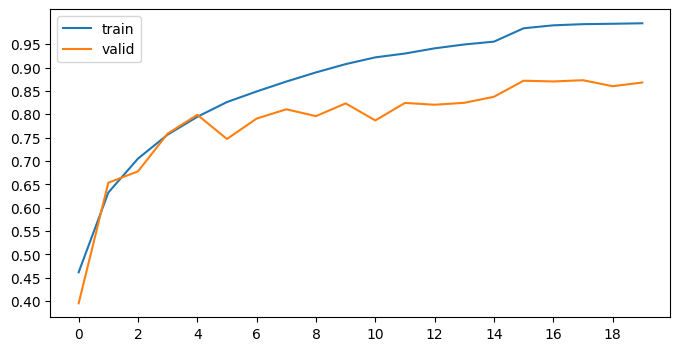

In [ ]:
model.evaluate(test_images, test_oh_labels)
show_history(history)

### 가중치 규제(Weight Regularizations)
* 개별 layer별로 tensorflow.keras.regularizers의 l1, l2, l1_l2 를 이용하여 가중치 규제를 적용할 수 있음.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2, l1_l2

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 512 filters Conv layer 추가하되 이후 MaxPooling을 적용하지 않고 strides는 2로 변경하여 출력 feature map 크기 조정
x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', kernel_regularizer=l2(1e-5), name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_38 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_52 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_39 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                         

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# [ ReduceLROnPlateau ] : 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# [ EarlyStopping ] :10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# 학습
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/30
1329/1329 [==============================] - 26s 16ms/step - loss: 1.6988 - accuracy: 0.3946 - val_loss: 1.5525 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 20s 15ms/step - loss: 1.2668 - accuracy: 0.5637 - val_loss: 1.2507 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 20s 15ms/step - loss: 1.0921 - accuracy: 0.6429 - val_loss: 0.9181 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 20s 15ms/step - loss: 0.9742 - accuracy: 0.6967 - val_loss: 0.9590 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 20s 15ms/step - loss: 0.8784 - accuracy: 0.7397 - val_loss: 1.0002 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 20s 15ms/step - loss: 0.7977 - accuracy: 0.7789 - val_loss: 0.8146 - val_accuracy: 0.7809 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 2s 6ms/step - loss: 1.0056 - accuracy: 0.8730


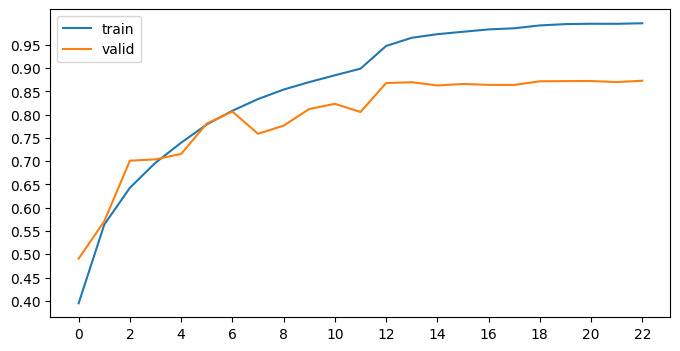

In [ ]:
model.evaluate(test_images, test_oh_labels)
show_history(history)